In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow as tf
import zipfile
import pathlib
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = "/content/clothing_photos.zip"
extracted_dir_path = "/content/photos"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [ ]:
data_dir = pathlib.Path("/content/photos/clothing_images")
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
file_list = os.listdir(data_dir)
print(file_list)

['shorts', 'socks', 'tshirts', 'dresses', 'skirts', 'underwear', 'shoes', 'shirts', 'outerwear', 'longPants']


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

500


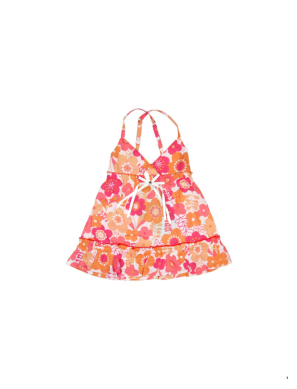

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/content/photos/clothing_images/dresses/12835.jpeg'  # Replace this with the actual path to an image
try:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes for clarity
    plt.show()  # Display the image using Matplotlib
except Exception as e:
    print(f"Error opening image: {e}")

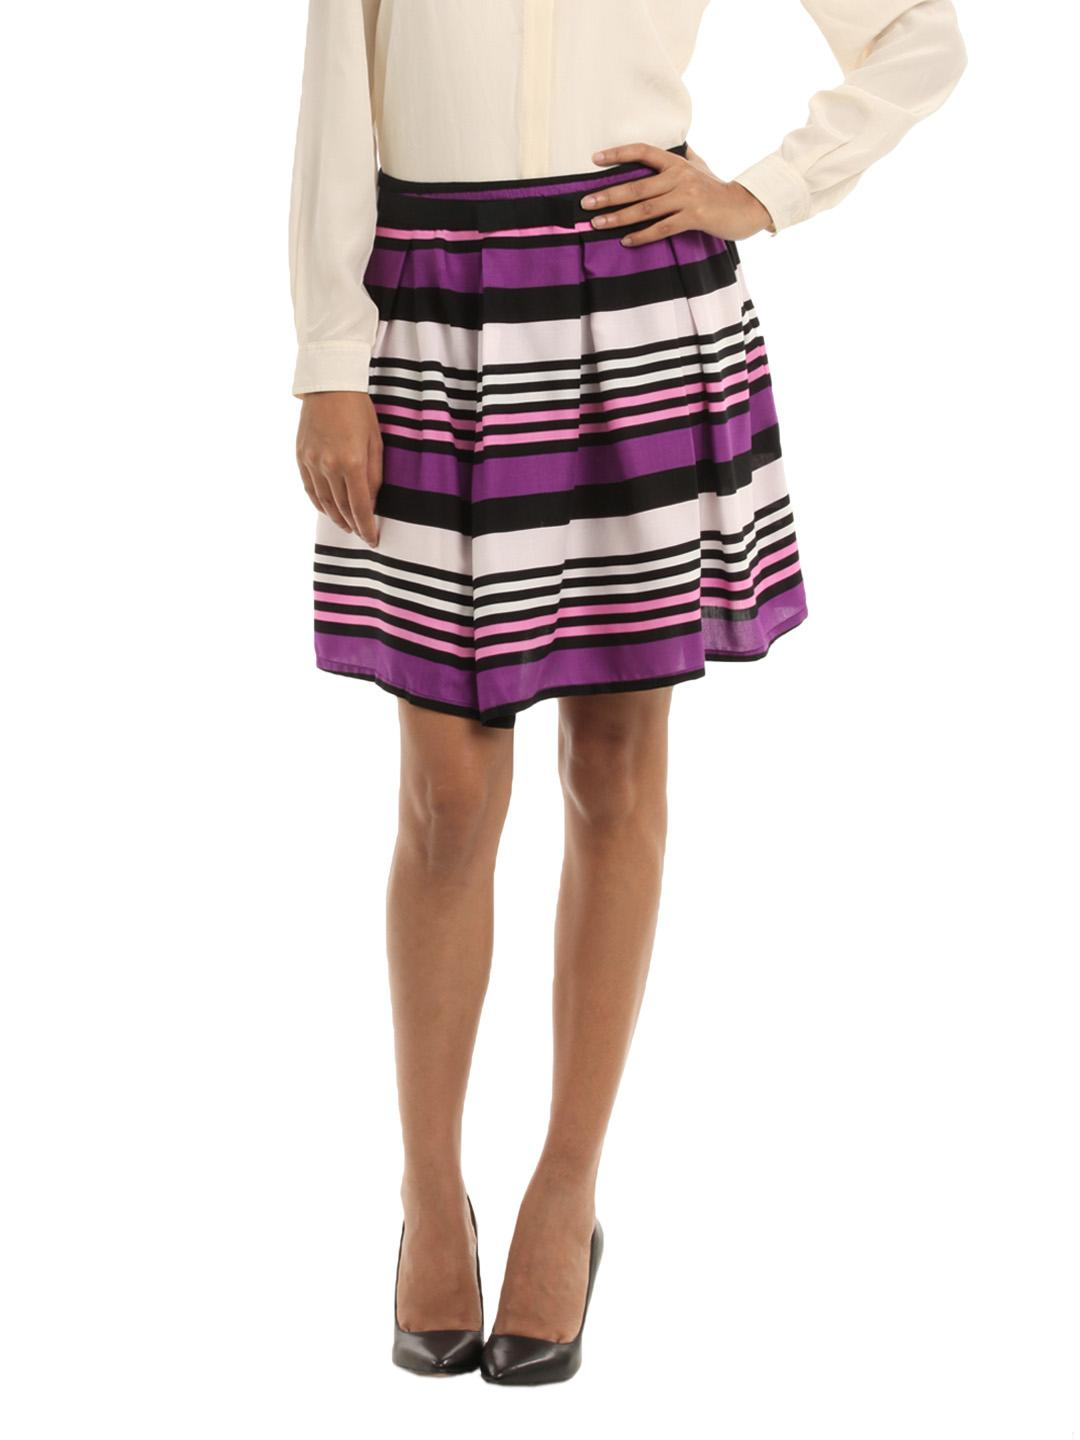

In [ ]:
skirts = list(data_dir.glob('skirts/*'))
PIL.Image.open(str(skirts[0]))

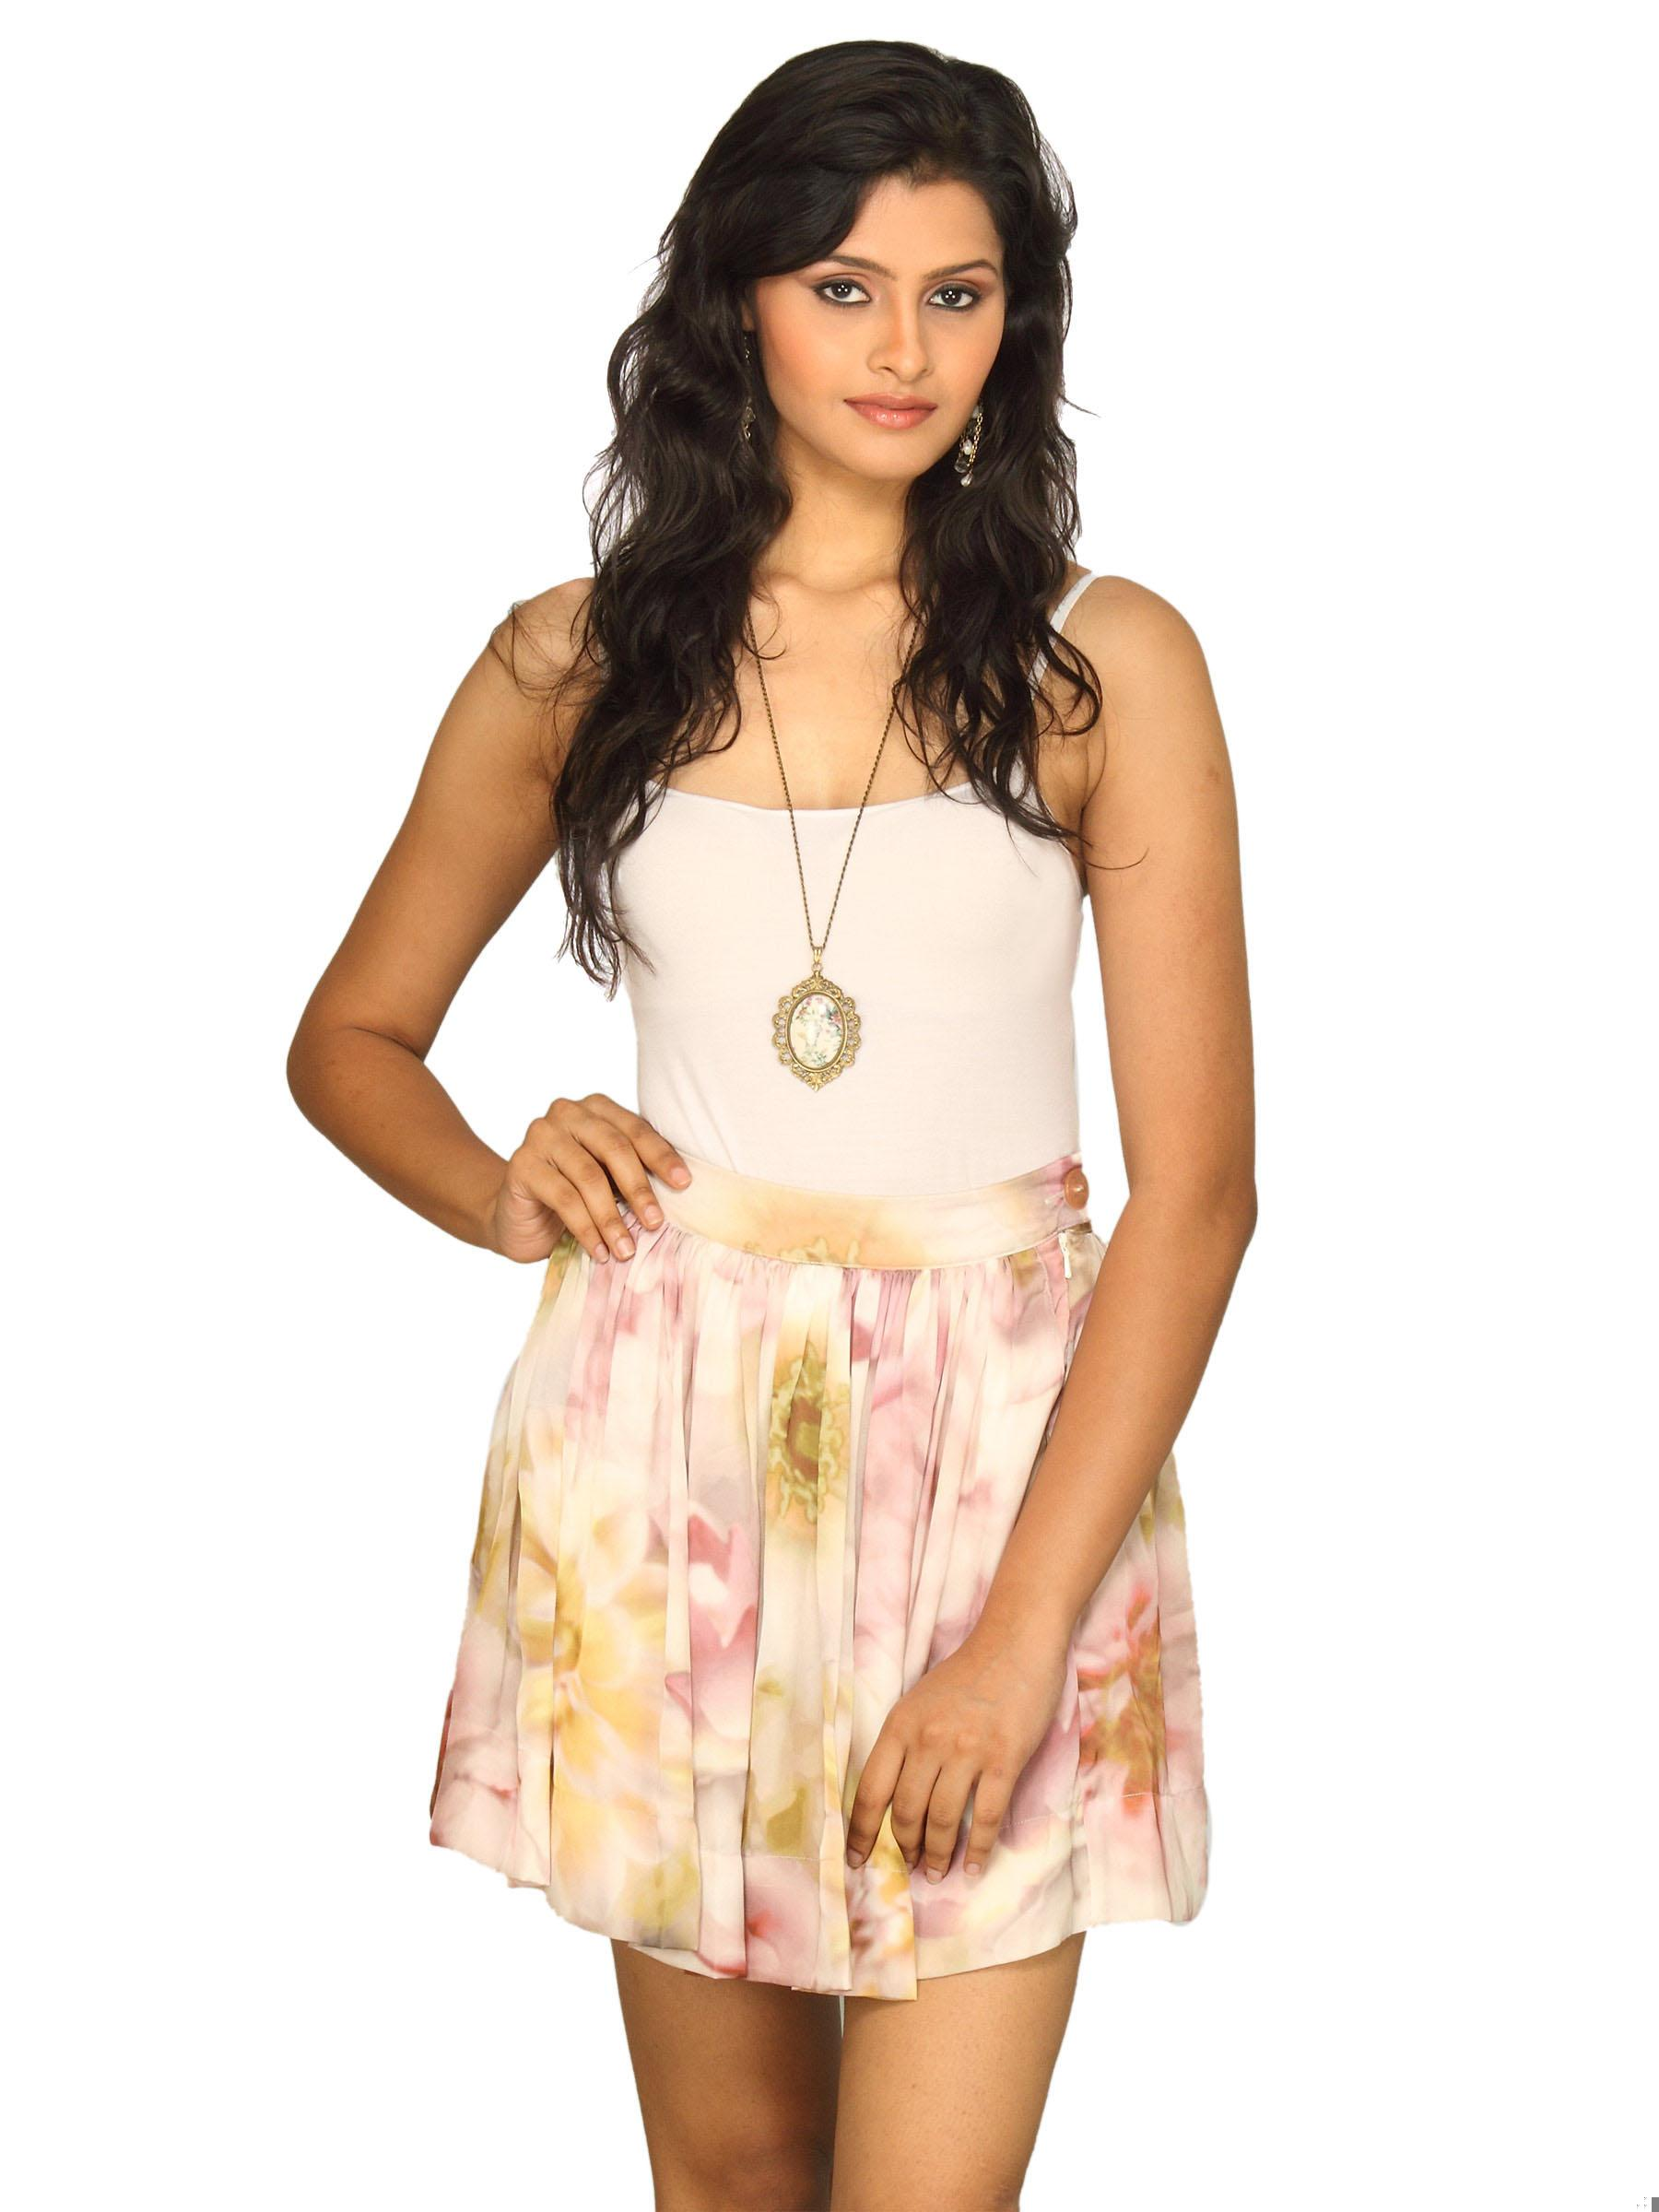

In [ ]:
PIL.Image.open(str(skirts[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.
Using 400 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 10 classes.
Using 100 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['dresses', 'longPants', 'outerwear', 'shirts', 'shoes', 'shorts', 'skirts', 'socks', 'tshirts', 'underwear']


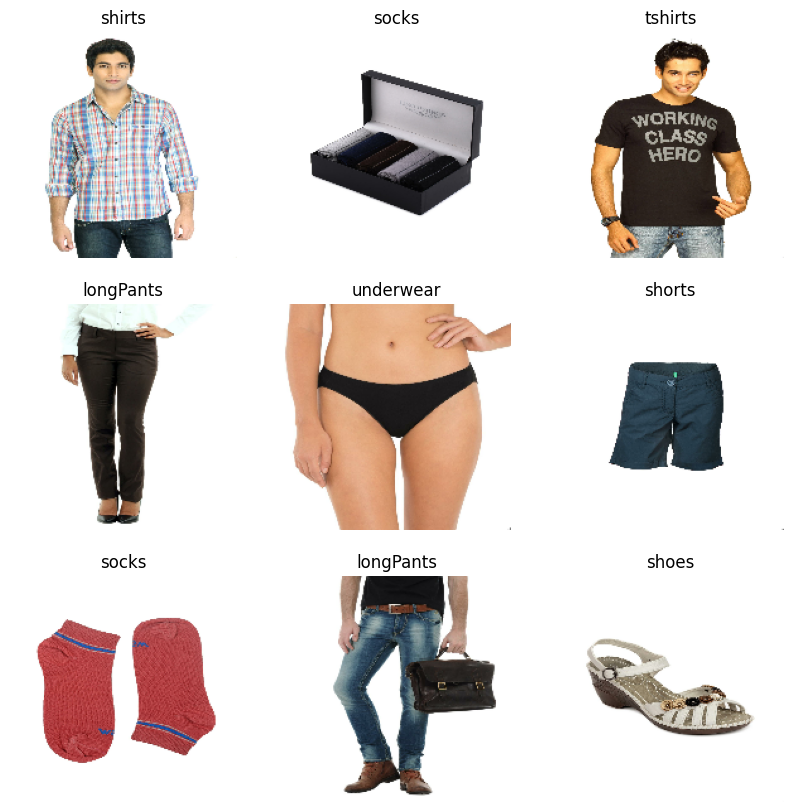

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0058823535 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs= 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 18s 1s/step - loss: 2.4924 - accuracy: 0.1275 - val_loss: 2.1662 - val_accuracy: 0.3900
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 1.8924 - accuracy: 0.4000 - val_loss: 1.3076 - val_accuracy: 0.6300
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 1.0300 - accuracy: 0.6350 - val_loss: 0.9270 - val_accuracy: 0.6800
Epoch 4/10
13/13 [==============================] - 13s 999ms/step - loss: 0.7112 - accuracy: 0.7475 - val_loss: 1.0745 - val_accuracy: 0.6400
Epoch 5/10
13/13 [==============================] - 16s 1s/step - loss: 0.7713 - accuracy: 0.7750 - val_loss: 0.9822 - val_accuracy: 0.7200
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 0.5435 - accuracy: 0.8300 - val_loss: 0.8395 - val_accuracy: 0.7500
Epoch 7/10
13/13 [==============================] - 12s 889ms/step - loss: 0.2901 - accuracy: 0.9100 - val_loss: 0.9356 - val_accuracy: 0.7700
Epoch 8/10
13/

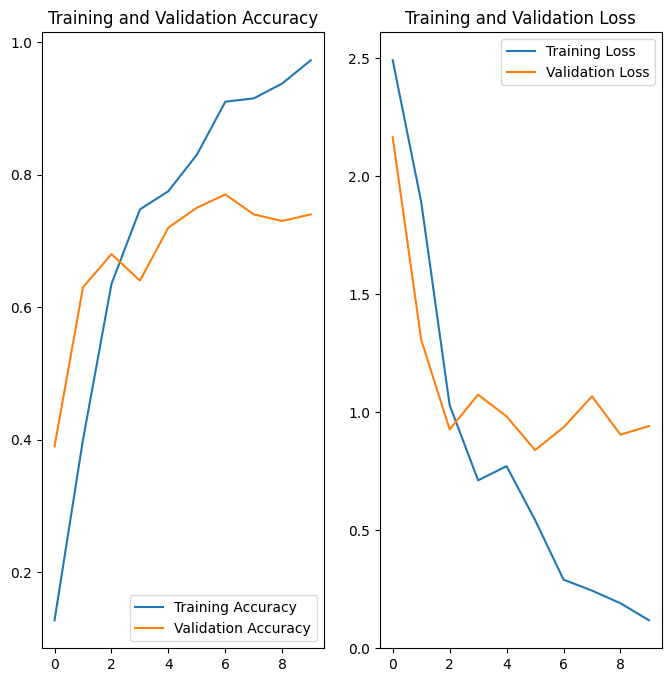

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
shirt = "/content/blackshirt.png"
img = tf.keras.utils.load_img(
    shirt, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 207ms/step
This image most likely belongs to underwear with a 46.76 percent confidence.


In [ ]:
jean = "/content/jeans.png"
img = tf.keras.utils.load_img(
    jean, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 37ms/step
This image most likely belongs to shorts with a 58.26 percent confidence.


In [ ]:
jacket = "/content/jacket.png"
img = tf.keras.utils.load_img(
    jacket, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to tshirts with a 50.47 percent confidence.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

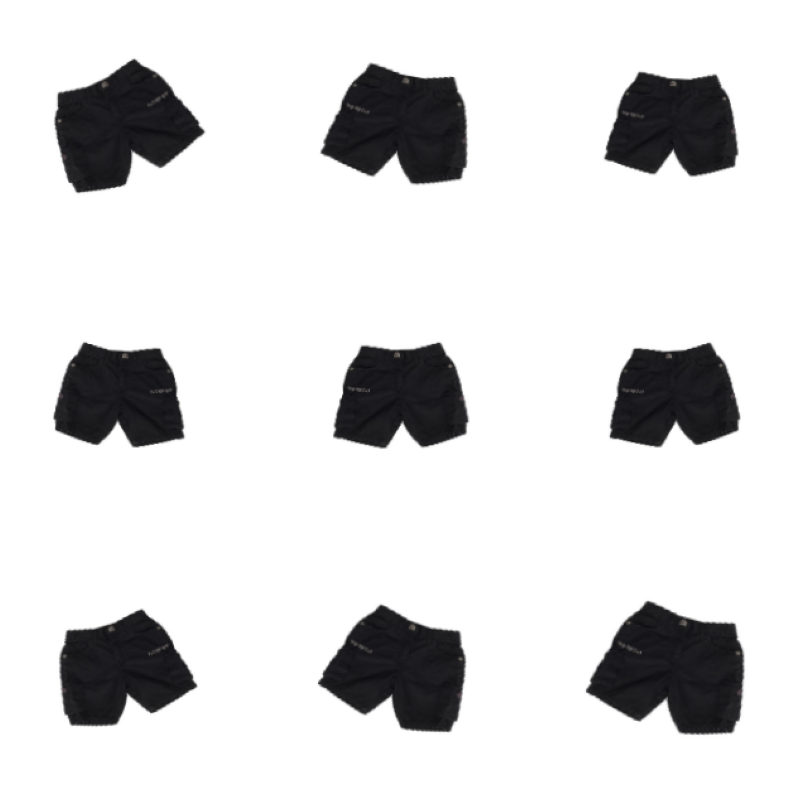

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
13/13 [==============================] - 21s 1s/step - loss: 2.5918 - accuracy: 0.1175 - val_loss: 2.2818 - val_accuracy: 0.2000
Epoch 2/30
13/13 [==============================] - 19s 1s/step - loss: 2.2659 - accuracy: 0.1800 - val_loss: 2.0936 - val_accuracy: 0.3900
Epoch 3/30
13/13 [==============================] - 17s 1s/step - loss: 2.0413 - accuracy: 0.3200 - val_loss: 1.6670 - val_accuracy: 0.3800
Epoch 4/30
13/13 [==============================] - 19s 2s/step - loss: 1.6782 - accuracy: 0.3700 - val_loss: 1.4103 - val_accuracy: 0.4200
Epoch 5/30
13/13 [==============================] - 20s 2s/step - loss: 1.3098 - accuracy: 0.5275 - val_loss: 1.1790 - val_accuracy: 0.5900
Epoch 6/30
13/13 [==============================] - 18s 1s/step - loss: 1.2704 - accuracy: 0.5800 - val_loss: 1.3926 - val_accuracy: 0.5200
Epoch 7/30
13/13 [==============================] - 18s 1s/step - loss: 1.2135 - accuracy: 0.5950 - val_loss: 1.2099 - val_accuracy: 0.5600
Epoch 8/30
13/13 [==

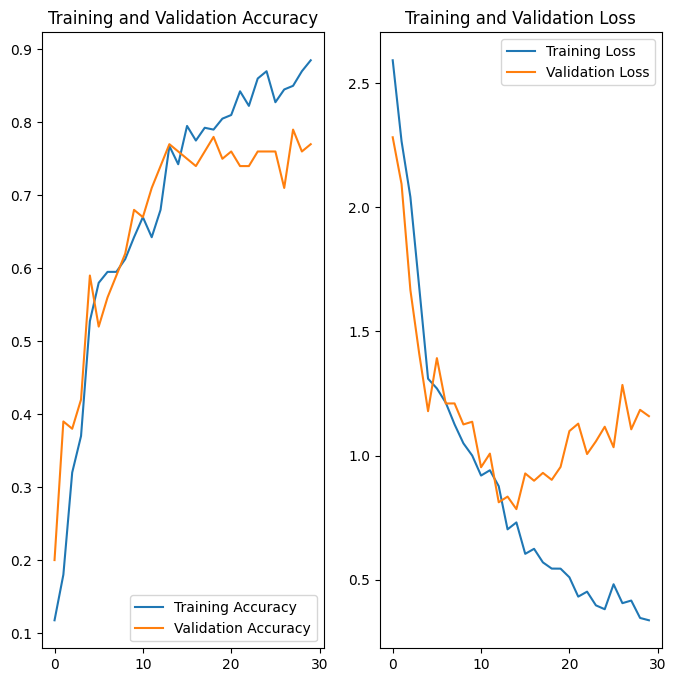

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
shirt = "/content/blackshirt.png"
img = tf.keras.utils.load_img(
    shirt, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 64ms/step
This image most likely belongs to socks with a 95.70 percent confidence.


In [ ]:
jean = "/content/jeans.png"
img = tf.keras.utils.load_img(
    jean, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 39ms/step
This image most likely belongs to socks with a 73.81 percent confidence.


In [ ]:
jacket = "/content/jacket.png"
img = tf.keras.utils.load_img(
    jacket, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 39ms/step
This image most likely belongs to outerwear with a 67.91 percent confidence.


In [ ]:
test1 = "/content/testc1.jpg"
img = tf.keras.utils.load_img(
    test1, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 147ms/step
This image most likely belongs to tshirts with a 97.38 percent confidence.


In [ ]:
test2 = "/content/testc2.jpg"
img = tf.keras.utils.load_img(
    test2, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
test3 = "/content/testc3.jpg"
img = tf.keras.utils.load_img(
    test3, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 84ms/step
This image most likely belongs to shirts with a 75.13 percent confidence.
1/1 [==============================] - 0s 74ms/step
This image most likely belongs to longPants with a 97.03 percent confidence.


In [ ]:
test4 = "/content/testc4.jpg"
img = tf.keras.utils.load_img(
    test4, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 43ms/step
This image most likely belongs to skirts with a 99.97 percent confidence.


In [ ]:
test5 = "/content/testc5.jpeg"
img = tf.keras.utils.load_img(
    test5, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 37ms/step
This image most likely belongs to skirts with a 52.98 percent confidence.


In [ ]:
test6 = "/content/testc6.jpg"
img = tf.keras.utils.load_img(
    test6, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 46ms/step
This image most likely belongs to skirts with a 95.20 percent confidence.
